## Source: https://huggingface.co/blog/sentiment-analysis-python

## Note: A Couple Hiccups
0. Issue occurs where you have to 'Run All' twice due to 'accelerate' library not working, restart and run again

1. Need the data from my Google Drive below and upload the .csv to session storage in Colab
https://drive.google.com/file/d/1GtHhmDXqx9bcXVJvPmGuJFQSdpoYmWv1/view?usp=sharing

2. Need to use your accesss token for HuggingFace

3. Issue with the Trainer() cell? Try running again with 'Restart Session and Run All'



# 0. How to Use Pre-trained Sentiment Analysis Models with Python

In [ ]:
# !pip install torch
# !pip install pytorch-accelerated

#!pip install accelerate -U
#!pip install transformers -U

In [ ]:
# There are more than 215 sentiment analysis models publicly available on the Hub and integrating them with Python just takes 5 lines of code
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
# Use a specific sentiment analysis model that is better suited to your language or use case by providing the name of the model.
# For example, if you want a sentiment analysis model for tweets, you can specify the model id
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model(data)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842}]

# 1. Activate GPU and Install Dependencies

In [ ]:
# Activate GPU for faster training by clicking on 'Runtime' > 'Change runtime type' and then selecting GPU as the Hardware accelerator
# Then check if GPU is available
import torch
torch.cuda.is_available()

True

In [ ]:
# Install required libraries
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


#2. Preprocess data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fin_labeled_data_small_subset.csv to fin_labeled_data_small_subset (1).csv


In [ ]:
# Load data
from datasets import Dataset, load_dataset
from google.colab import files
import pandas as pd

# Example IMDB Dataset
#imdb = load_dataset("imdb")
#print("IMDB\n", imdb)
#print(imdb['train'][0])

# GUI for File Upload
#uploaded = files.upload()

# Processing 'fin_data.csv' from Section 16.4
#df = pd.read_csv("fin_data.csv")
#print("MAX", df['News Headline'].str.len().max())
#df['Label'] = df['Sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})
#del df['Unnamed: 0']
#df.to_csv('fin_data.csv', index=False)
#print(df)


fin = load_dataset("csv", data_files="fin_labeled_data_small_subset.csv", split="train")
fin = fin.rename_column("News Headline", "text")
fin = fin.rename_column("Label", "label")
print("FIN\n", fin)

fin = fin.train_test_split(test_size=0.2)
print("FIN Train Test\n", fin)

FIN
 Dataset({
    features: ['text', 'label'],
    num_rows: 1500
})
FIN Train Test
 DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})


In [ ]:
# Create a smaller training dataset for faster training times
small_train_dataset = fin["train"].shuffle(seed=0).select([i for i in list(range(1200))])
small_test_dataset = fin["test"].shuffle(seed=0).select([i for i in list(range(300))])
print("Train", small_train_dataset[0])
print("Test", small_test_dataset[0])

Train {'text': "Goldman's Currie Sees Worst Oil Demand Shock in a Decade", 'label': 0}
Test {'text': '10 takeaways from the second-quarter results of Infosys', 'label': 2}


In [ ]:
# Set DistilBERT tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
print(tokenized_train[0])
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "Goldman's Currie Sees Worst Oil Demand Shock in a Decade", 'label': 0, 'input_ids': [101, 17765, 1005, 1055, 20667, 5927, 5409, 3514, 5157, 5213, 1999, 1037, 5476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
# Use data_collector to convert our samples to PyTorch tensors and concatenate them with the correct amount of padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Training the model

In [ ]:
!pip install evaluate

In [ ]:
# Define DistilBERT as our base model:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the evaluation metrics
# Loss Functions - https://www.datacamp.com/tutorial/loss-function-in-machine-learning
# HuggingFace Loss Function Usage - https://stackoverflow.com/questions/71581197/what-is-the-loss-function-used-in-trainer-from-the-transformers-library-of-huggi
import numpy as np
#from datasets import load_metric
from evaluate import load

from sklearn.metrics import mean_squared_error


def compute_metrics(eval_pred):
    #load_accuracy = load_metric("accuracy")
    #load_f1 = load_metric("f1")
    load_accuracy = load("accuracy")
    load_f1 = load("f1")
    load_mse = load("mse")
    load_mae = load("mae")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    mse = load_mse.compute(predictions=predictions, references=labels, squared=True)["mse"]
    mae = load_mae.compute(predictions=predictions, references=labels)["mae"]
    return {"accuracy": accuracy, "f1": f1, "mse": mse, "mae": mae}

In [ ]:
# Log in to your Hugging Face account
# Get your API token here https://huggingface.co/settings/token
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install accelerate -U
!pip install transformers -U

In [ ]:
# Define a new Trainer with all the objects we constructed so far

from torch import nn
from transformers import TrainingArguments, Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

repo_name = "financial-sentiment-model-1500-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train the model
trainer.train()

Step,Training Loss


TrainOutput(global_step=150, training_loss=0.8640689086914063, metrics={'train_runtime': 35.1286, 'train_samples_per_second': 68.32, 'train_steps_per_second': 4.27, 'total_flos': 31747206165408.0, 'train_loss': 0.8640689086914063, 'epoch': 2.0})

In [ ]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 0.8236415982246399,
 'eval_accuracy': 0.49333333333333335,
 'eval_f1': 0.4933333333333334,
 'eval_mse': 0.6966666666666667,
 'eval_mae': 0.57,
 'eval_runtime': 2.8836,
 'eval_samples_per_second': 104.038,
 'eval_steps_per_second': 6.589,
 'epoch': 2.0}

In [ ]:
# Upload the model to the Hub
trainer.push_to_hub()

events.out.tfevents.1720162612.7b252431b739.3391.0:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1720162657.7b252431b739.3391.1:   0%|          | 0.00/551 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kevinwlip/financial-sentiment-model-1500-samples/commit/e80cc7c05315a43565307b54a5ac5828b9302a2c', commit_message='End of training', commit_description='', oid='e80cc7c05315a43565307b54a5ac5828b9302a2c', pr_url=None, pr_revision=None, pr_num=None)

# 4. Analyzing new data with multiple models - Self Sentiment Model, Bert Model, Twitter Roberta Model, ProsusAI Finbert Model, Sigma's Financial Sentiment Analysis Model, and DistilRoberta Financial Sentiment Model

In [ ]:
# Run inferences with your new model using Pipeline - https://huggingface.co/kevinwlip/financial-sentiment-model-1500-samples
from transformers import pipeline

sentiment_model = pipeline(model="kevinwlip/financial-sentiment-model-1500-samples")

sentiment_model(["I love this movie", "This movie sucks!"])

sentiment_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.4741867482662201},
 {'label': 'LABEL_1', 'score': 0.5268896222114563},
 {'label': 'LABEL_1', 'score': 0.44183188676834106},
 {'label': 'LABEL_1', 'score': 0.4872543513774872},
 {'label': 'LABEL_1', 'score': 0.5432332158088684},
 {'label': 'LABEL_1', 'score': 0.5172690153121948},
 {'label': 'LABEL_1', 'score': 0.4384147822856903},
 {'label': 'LABEL_1', 'score': 0.6423308253288269},
 {'label': 'LABEL_1', 'score': 0.5011005401611328},
 {'label': 'LABEL_1', 'score': 0.6165879964828491},
 {'label': 'LABEL_2', 'score': 0.7321680188179016},
 {'label': 'LABEL_2', 'score': 0.7750108242034912},
 {'label': 'LABEL_2', 'score': 0.6409174203872681},
 {'label': 'LABEL_2', 'score': 0.6391785740852356},
 {'label': 'LABEL_2', 'score': 0.6925245523452759}]

In [ ]:
# Try using the latest Bert Model - https://huggingface.co/google-bert/bert-base-uncased
from transformers import pipeline

bert_model = pipeline("sentiment-analysis", model="google-bert/bert-base-uncased")

bert_model(["I love this movie", "This movie sucks!"])

bert_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.5133516192436218},
 {'label': 'LABEL_0', 'score': 0.5102410912513733},
 {'label': 'LABEL_0', 'score': 0.5599414110183716},
 {'label': 'LABEL_0', 'score': 0.5019081234931946},
 {'label': 'LABEL_0', 'score': 0.5638871192932129},
 {'label': 'LABEL_0', 'score': 0.5510928630828857},
 {'label': 'LABEL_0', 'score': 0.539638876914978},
 {'label': 'LABEL_0', 'score': 0.5098827481269836},
 {'label': 'LABEL_0', 'score': 0.5092596411705017},
 {'label': 'LABEL_0', 'score': 0.5763128399848938},
 {'label': 'LABEL_0', 'score': 0.5446516871452332},
 {'label': 'LABEL_0', 'score': 0.53670334815979},
 {'label': 'LABEL_0', 'score': 0.5440858602523804},
 {'label': 'LABEL_0', 'score': 0.5356974005699158},
 {'label': 'LABEL_0', 'score': 0.5273991823196411}]

In [ ]:
# Try using the latest Twitter Roberta Model - https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
from transformers import pipeline

roberta_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

roberta_model(["I love this movie", "This movie sucks!"])

roberta_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'negative', 'score': 0.521594762802124},
 {'label': 'negative', 'score': 0.6893202662467957},
 {'label': 'neutral', 'score': 0.6284891963005066},
 {'label': 'negative', 'score': 0.8247576951980591},
 {'label': 'negative', 'score': 0.5967463254928589},
 {'label': 'positive', 'score': 0.7096949219703674},
 {'label': 'positive', 'score': 0.8983083367347717},
 {'label': 'positive', 'score': 0.5159177780151367},
 {'label': 'positive', 'score': 0.7258636355400085},
 {'label': 'neutral', 'score': 0.6438232660293579},
 {'label': 'neutral', 'score': 0.9298118352890015},
 {'label': 'neutral', 'score': 0.8773127198219299},
 {'label': 'positive', 'score': 0.8506599068641663},
 {'label': 'positive', 'score': 0.7193374037742615},
 {'label': 'neutral', 'score': 0.5253719687461853}]

In [ ]:
# Try using the latest ProsusAI Finbert Model - https://huggingface.co/ProsusAI/finbert
from transformers import pipeline

finbert_model = pipeline("sentiment-analysis", model="ProsusAI/finbert")

finbert_model(["I love this movie", "This movie sucks!"])

finbert_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'negative', 'score': 0.9179691076278687},
 {'label': 'negative', 'score': 0.9538722038269043},
 {'label': 'neutral', 'score': 0.8057689070701599},
 {'label': 'negative', 'score': 0.5092411637306213},
 {'label': 'negative', 'score': 0.7875530123710632},
 {'label': 'negative', 'score': 0.5851684808731079},
 {'label': 'positive', 'score': 0.6592949628829956},
 {'label': 'positive', 'score': 0.9493573307991028},
 {'label': 'positive', 'score': 0.8135282397270203},
 {'label': 'positive', 'score': 0.9495117664337158},
 {'label': 'neutral', 'score': 0.9443269968032837},
 {'label': 'neutral', 'score': 0.9468695521354675},
 {'label': 'neutral', 'score': 0.6568445563316345},
 {'label': 'neutral', 'score': 0.7671145796775818},
 {'label': 'neutral', 'score': 0.9020786285400391}]

In [ ]:
# Try using the latest Sigma's Financial Sentiment Analysis Model - https://huggingface.co/Sigma/financial-sentiment-analysis
from transformers import pipeline

sigmafsa_model = pipeline("sentiment-analysis", model="Sigma/financial-sentiment-analysis")

sigmafsa_model(["I love this movie", "This movie sucks!"])

sigmafsa_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.9958165287971497},
 {'label': 'LABEL_0', 'score': 0.9943016767501831},
 {'label': 'LABEL_0', 'score': 0.9543273448944092},
 {'label': 'LABEL_1', 'score': 0.9991251826286316},
 {'label': 'LABEL_0', 'score': 0.9966831803321838},
 {'label': 'LABEL_2', 'score': 0.6872993111610413},
 {'label': 'LABEL_1', 'score': 0.995182454586029},
 {'label': 'LABEL_2', 'score': 0.9958404898643494},
 {'label': 'LABEL_1', 'score': 0.9837798476219177},
 {'label': 'LABEL_2', 'score': 0.9983506202697754},
 {'label': 'LABEL_1', 'score': 0.9991958737373352},
 {'label': 'LABEL_1', 'score': 0.9991486072540283},
 {'label': 'LABEL_1', 'score': 0.9993591904640198},
 {'label': 'LABEL_1', 'score': 0.9979532957077026},
 {'label': 'LABEL_1', 'score': 0.9979967474937439}]

In [ ]:
# Try using the latest DistilRoberta Financial Sentiment Model - https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

from transformers import pipeline

distilroberta_model = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

distilroberta_model(["I love this movie", "This movie sucks!"])

distilroberta_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'negative', 'score': 0.9983526468276978},
 {'label': 'negative', 'score': 0.9978590607643127},
 {'label': 'neutral', 'score': 0.9973788261413574},
 {'label': 'negative', 'score': 0.9873886108398438},
 {'label': 'negative', 'score': 0.9981669187545776},
 {'label': 'positive', 'score': 0.9987959861755371},
 {'label': 'positive', 'score': 0.999421238899231},
 {'label': 'positive', 'score': 0.9997286200523376},
 {'label': 'positive', 'score': 0.9993207454681396},
 {'label': 'positive', 'score': 0.9993876218795776},
 {'label': 'neutral', 'score': 0.9998924732208252},
 {'label': 'neutral', 'score': 0.9998958110809326},
 {'label': 'neutral', 'score': 0.9998511075973511},
 {'label': 'neutral', 'score': 0.9957629442214966},
 {'label': 'neutral', 'score': 0.9998747110366821}]

# (Just for learning) 5. Fine-Tune KNN Classifier with data - Non-Huggingface

In [ ]:
""" Uncomment to Run
# KNN Model
# Self Model

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler # Use MaxAbsScaler for sparse input
from sklearn.feature_extraction.text import TfidfVectorizer # Import TF-IDF Vectorizer
from sklearn.metrics import f1_score

X_train = small_train_dataset['text']
y_train = small_train_dataset['label']

X_test = small_test_dataset['text']
y_test = small_test_dataset['label']

knn_pipe = Pipeline([('tfidf', TfidfVectorizer()), # Transform text to numerical features
                     ('mms', MaxAbsScaler()),
                     ('knn', KNeighborsClassifier())])

params = [{'knn__n_neighbors': [5,10,15,20,25],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [1,2,3,4,5]}]

gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)

gs_knn.fit(X_train, y_train)

print("Best Hyperparameters: ")
print(gs_knn.best_params_)

print("Score on Training Data: ")
print(gs_knn.score(X_train, y_train))

print("pred_labels: ")
pred_labels = gs_knn.predict(X_test)
print(pred_labels)

f1 = f1_score(y_test, pred_labels, average='macro')
print(f"F1 score with 'macro'-averaging is {f1.round(5)}")
"""

' Uncomment to Run\n# KNN Model\n# Self Model\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import MaxAbsScaler # Use MaxAbsScaler for sparse input\nfrom sklearn.feature_extraction.text import TfidfVectorizer # Import TF-IDF Vectorizer\nfrom sklearn.metrics import f1_score\n\nX_train = small_train_dataset[\'text\']\ny_train = small_train_dataset[\'label\']\n\nX_test = small_test_dataset[\'text\']\ny_test = small_test_dataset[\'label\']\n\nknn_pipe = Pipeline([(\'tfidf\', TfidfVectorizer()), # Transform text to numerical features\n                     (\'mms\', MaxAbsScaler()),\n                     (\'knn\', KNeighborsClassifier())])\n\nparams = [{\'knn__n_neighbors\': [5,10,15,20,25],\n         \'knn__weights\': [\'uniform\', \'distance\'],\n         \'knn__leaf_size\': [1,2,3,4,5]}]\n\ngs_knn = GridSearchCV(knn_pipe,\n                      param_grid=params,\n 

In [ ]:
""" Uncomment to Run
# Test with Hyperparameters
knn = Pipeline([('tfidf', TfidfVectorizer()), # Transform text to numerical features
                ('mms', MaxAbsScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance', leaf_size=1))])

knn.fit(X_train, y_train)

print("Score on Training Data: ")
print(knn.score(X_train, y_train))

print("pred_labels: ")
pred_labels = knn.predict(X_test)
print(pred_labels)

f1 = f1_score(y_test, pred_labels, average='macro')
print(f"F1 score with 'macro'-averaging is {f1.round(5)}")


### On previous run, seems data-dependent, did better with '20' neighbors (0.565) rather than the suggested '10' neighbors (0.479), the predicted best was using '10' neighbors ###
"""

' Uncomment to Run\n# Test with Hyperparameters\nknn = Pipeline([(\'tfidf\', TfidfVectorizer()), # Transform text to numerical features\n                (\'mms\', MaxAbsScaler()),\n                (\'knn\', KNeighborsClassifier(n_neighbors=5, weights=\'distance\', leaf_size=1))])\n\nknn.fit(X_train, y_train)\n\nprint("Score on Training Data: ")\nprint(knn.score(X_train, y_train))\n\nprint("pred_labels: ")\npred_labels = knn.predict(X_test)\nprint(pred_labels)\n\nf1 = f1_score(y_test, pred_labels, average=\'macro\')\nprint(f"F1 score with \'macro\'-averaging is {f1.round(5)}")\n\n\n### On previous run, seems data-dependent, did better with \'20\' neighbors (0.565) rather than the suggested \'10\' neighbors (0.479), the predicted best was using \'10\' neighbors ###\n'

# Analysis - Please click into here to read the data easier.

Starting from Step 4. I was analyzing new data with multiple models - Self Sentiment Model, Bert Model, Twitter Roberta Model, ProsusAI Finbert Model, Sigma's Financial Sentiment Analysis Model, and DistilRoberta Financial Sentiment Model.

I ran the same 5 Negative, 5 Positive, and 5 Neutral statements taken from my 1500 sample dataset and it seemed like ProsusAI Finbert and The DistilRoberta Financial Model performed better, both accurately predicting with at most 2 wrong on a few tries.

After fine tuning the three selected models for analysis, I noticed that two of the models' predictions improved (Self Sentiment Model and DistilRoberta Financial Sentiment Model), the exception being ProsusAI Finbert Model which did worse. With 'distilroberta_model_tuned' predicting on the labels perfectly on the 15 statements.

I believe I will use the DistilRoberta overall for my Capstone due to its accuracy overall.


sentiment_model - LABEL_0: Negative, LABEL_1: Positive, LABEL_2: Neutral
[{'label': 'LABEL_0', 'score': 0.47167298197746277},
 {'label': 'LABEL_0', 'score': 0.34854891896247864},
 {'label': 'LABEL_2', 'score': 0.4000025987625122},   X
 {'label': 'LABEL_0', 'score': 0.37904348969459534},
 {'label': 'LABEL_0', 'score': 0.3914853036403656},
 {'label': 'LABEL_0', 'score': 0.45039665699005127},  X
 {'label': 'LABEL_2', 'score': 0.6083877086639404},   X
 {'label': 'LABEL_1', 'score': 0.6673786640167236},
 {'label': 'LABEL_2', 'score': 0.5597862601280212},   X
 {'label': 'LABEL_1', 'score': 0.6164636611938477},
 {'label': 'LABEL_2', 'score': 0.606207549571991},
 {'label': 'LABEL_2', 'score': 0.7558310031890869},
 {'label': 'LABEL_2', 'score': 0.6832563877105713},
 {'label': 'LABEL_2', 'score': 0.6757391095161438},
 {'label': 'LABEL_2', 'score': 0.6516631245613098}]


sentiment_model_tuned - LABEL_0: Negative, LABEL_1: Positive, LABEL_2: Neutral
[{'label': 'LABEL_0', 'score': 0.9350849986076355},
 {'label': 'LABEL_0', 'score': 0.9179285764694214},
 {'label': 'LABEL_0', 'score': 0.8534387946128845},
 {'label': 'LABEL_0', 'score': 0.9133590459823608},
 {'label': 'LABEL_0', 'score': 0.9111049771308899},
 {'label': 'LABEL_0', 'score': 0.9243319034576416},   X
 {'label': 'LABEL_2', 'score': 0.5825300216674805},   X
 {'label': 'LABEL_1', 'score': 0.922419548034668},
 {'label': 'LABEL_1', 'score': 0.6049041748046875},
 {'label': 'LABEL_1', 'score': 0.8833795785903931},
 {'label': 'LABEL_2', 'score': 0.741992175579071},
 {'label': 'LABEL_2', 'score': 0.8895606994628906},
 {'label': 'LABEL_2', 'score': 0.8496867418289185},
 {'label': 'LABEL_2', 'score': 0.7117111682891846},
 {'label': 'LABEL_2', 'score': 0.7510005831718445}]


 finbert_model
[{'label': 'negative', 'score': 0.9179691076278687},
 {'label': 'negative', 'score': 0.9538722038269043},
 {'label': 'neutral', 'score': 0.8057689070701599},   X
 {'label': 'negative', 'score': 0.5092411637306213},
 {'label': 'negative', 'score': 0.7875530123710632},
 {'label': 'negative', 'score': 0.5851684808731079},  X
 {'label': 'positive', 'score': 0.6592949628829956},
 {'label': 'positive', 'score': 0.9493573307991028},
 {'label': 'positive', 'score': 0.8135282397270203},
 {'label': 'positive', 'score': 0.9495117664337158},
 {'label': 'neutral', 'score': 0.9443269968032837},
 {'label': 'neutral', 'score': 0.9468695521354675},
 {'label': 'neutral', 'score': 0.6568445563316345},
 {'label': 'neutral', 'score': 0.7671145796775818},
 {'label': 'neutral', 'score': 0.9020786285400391}]


finbert_model_tuned
[{'label': 'positive', 'score': 0.6108507513999939},  X
 {'label': 'negative', 'score': 0.4695791006088257},
 {'label': 'positive', 'score': 0.47678446769714355}, X
 {'label': 'positive', 'score': 0.47963422536849976}, X
 {'label': 'positive', 'score': 0.7220267057418823},  X
 {'label': 'positive', 'score': 0.5846428871154785},
 {'label': 'positive', 'score': 0.45479774475097656},
 {'label': 'negative', 'score': 0.7035203576087952},  X
 {'label': 'negative', 'score': 0.4356476366519928},  X
 {'label': 'positive', 'score': 0.519198477268219},
 {'label': 'neutral', 'score': 0.893254816532135},
 {'label': 'neutral', 'score': 0.9592297673225403},
 {'label': 'neutral', 'score': 0.767744243144989},
 {'label': 'neutral', 'score': 0.9325315356254578},
 {'label': 'neutral', 'score': 0.5289221405982971}]


distilroberta_model
[{'label': 'negative', 'score': 0.9983526468276978},
 {'label': 'negative', 'score': 0.9978590607643127},
 {'label': 'neutral', 'score': 0.9973788261413574},   X
 {'label': 'negative', 'score': 0.9873886108398438},
 {'label': 'negative', 'score': 0.9981669187545776},
 {'label': 'positive', 'score': 0.9987959861755371},
 {'label': 'positive', 'score': 0.999421238899231},
 {'label': 'positive', 'score': 0.9997286200523376},
 {'label': 'positive', 'score': 0.9993207454681396},
 {'label': 'positive', 'score': 0.9993876218795776},
 {'label': 'neutral', 'score': 0.9998924732208252},
 {'label': 'neutral', 'score': 0.9998958110809326},
 {'label': 'neutral', 'score': 0.9998511075973511},
 {'label': 'neutral', 'score': 0.9957629442214966},
 {'label': 'neutral', 'score': 0.9998747110366821}]


distilroberta_model_tuned
[{'label': 'negative', 'score': 0.9701110124588013},
 {'label': 'negative', 'score': 0.969354510307312},
 {'label': 'negative', 'score': 0.5647386312484741},
 {'label': 'negative', 'score': 0.8065626621246338},
 {'label': 'negative', 'score': 0.9823943972587585},
 {'label': 'neutral', 'score': 0.8046205043792725},
 {'label': 'neutral', 'score': 0.7604220509529114},
 {'label': 'neutral', 'score': 0.9848699569702148},
 {'label': 'neutral', 'score': 0.9329875707626343},
 {'label': 'neutral', 'score': 0.975169837474823},
 {'label': 'positive', 'score': 0.8283220529556274},
 {'label': 'positive', 'score': 0.7942936420440674},
 {'label': 'positive', 'score': 0.8845605850219727},
 {'label': 'neutral', 'score': 0.5417729020118713},
 {'label': 'positive', 'score': 0.6406908631324768}]   ALL PASS


Test Data

In [ ]:
small_test_dataset[:]

{'text': ['10 takeaways from the second-quarter results of Infosys',
  'UnitedHealth stock price target raised to $338 from $303 at CFRA',
  "Did Business Growth Power Retractable Technologies's (NYSEMKT:RVP) Share Price Gain of 103%?",
  'IIL Q3 net rises 45% to Rs 6.76 crore',
  'Sell Asian Paints Ltd with target price of Rs 450: Mitesh Thacker',
  'Mundra Port FY11 net up 35.82% at Rs 918.14 cr',
  'Santa Claus rally',
  'Beware the dawn of the corporate dead https://t.co/b2fYLGY3BI',
  'Turun kaupunkin , Finland based company has awarded contract to Lemminkainen Talotekniikka Oy for electrical installation work .',
  "Demand for HK Property Is Very Strong, Says Midland Realty's Lau",
  '$SAVE - Spirit Airlines (SAVE) Investor Presentation - Slideshow. Subscribe to Seeking Alpha for more:… https://t.co/p8zUL1L274',
  'Shriram City Union Finance Q2 profit rises 10.5% to Rs 152.31 crore',
  'Record Year for the Iberchem Group With the Completion of Two Acquisitions in Flavors and 19% 

sentiment_model, using 300 Test Data

In [ ]:
smt = sentiment_model(small_test_dataset[:]['text'])
smt

[{'label': 'LABEL_2', 'score': 0.7150927186012268},
 {'label': 'LABEL_1', 'score': 0.6093910336494446},
 {'label': 'LABEL_1', 'score': 0.5969949960708618},
 {'label': 'LABEL_1', 'score': 0.6073538661003113},
 {'label': 'LABEL_1', 'score': 0.44500496983528137},
 {'label': 'LABEL_1', 'score': 0.6150986552238464},
 {'label': 'LABEL_2', 'score': 0.6951046586036682},
 {'label': 'LABEL_2', 'score': 0.8348799347877502},
 {'label': 'LABEL_2', 'score': 0.784134030342102},
 {'label': 'LABEL_1', 'score': 0.4245246946811676},
 {'label': 'LABEL_2', 'score': 0.8123855590820312},
 {'label': 'LABEL_1', 'score': 0.6237376928329468},
 {'label': 'LABEL_1', 'score': 0.6034786701202393},
 {'label': 'LABEL_1', 'score': 0.5905061960220337},
 {'label': 'LABEL_1', 'score': 0.4808385372161865},
 {'label': 'LABEL_2', 'score': 0.6228299140930176},
 {'label': 'LABEL_1', 'score': 0.6120337843894958},
 {'label': 'LABEL_1', 'score': 0.5840061902999878},
 {'label': 'LABEL_1', 'score': 0.524246871471405},
 {'label': 'L

In [ ]:
smt_labels = [item['label'].split('_')[1] for item in smt[:]]
smt_labels = list(map(int, smt_labels))

In [ ]:
smt_matches = [x for x,y in zip(small_test_dataset[:]['label'], smt_labels) if x == y]
len(smt_matches)

148

finbert_model, using 300 Test Data

In [ ]:
fmt = finbert_model(small_test_dataset[:]['text'])
fmt

[{'label': 'neutral', 'score': 0.8413408994674683},
 {'label': 'positive', 'score': 0.943257749080658},
 {'label': 'positive', 'score': 0.7600148916244507},
 {'label': 'positive', 'score': 0.9320475459098816},
 {'label': 'neutral', 'score': 0.9112049341201782},
 {'label': 'positive', 'score': 0.9503670930862427},
 {'label': 'neutral', 'score': 0.9132376313209534},
 {'label': 'neutral', 'score': 0.8148107528686523},
 {'label': 'positive', 'score': 0.9487452507019043},
 {'label': 'positive', 'score': 0.9276408553123474},
 {'label': 'neutral', 'score': 0.9424610137939453},
 {'label': 'positive', 'score': 0.9341146349906921},
 {'label': 'positive', 'score': 0.9546095728874207},
 {'label': 'positive', 'score': 0.9316514134407043},
 {'label': 'neutral', 'score': 0.873873770236969},
 {'label': 'negative', 'score': 0.4737952947616577},
 {'label': 'positive', 'score': 0.9527637958526611},
 {'label': 'negative', 'score': 0.973965048789978},
 {'label': 'negative', 'score': 0.9745582938194275},
 {

In [ ]:
fmt_labels = [0 if item['label'] == 'negative' else 1 if item['label'] == 'positive' else 2 for item in fmt[:]]

In [ ]:
fmt_matches = [x for x,y in zip(small_test_dataset[:]['label'], fmt_labels) if x == y]
len(fmt_matches)

207

distilroberta_model, using 300 Test Data

In [ ]:
dmt = distilroberta_model(small_test_dataset[:]['text'])
dmt

[{'label': 'neutral', 'score': 0.9998725652694702},
 {'label': 'positive', 'score': 0.9993341565132141},
 {'label': 'positive', 'score': 0.9995354413986206},
 {'label': 'positive', 'score': 0.9997090697288513},
 {'label': 'neutral', 'score': 0.9998630285263062},
 {'label': 'positive', 'score': 0.9997137188911438},
 {'label': 'neutral', 'score': 0.9997531771659851},
 {'label': 'neutral', 'score': 0.9997056126594543},
 {'label': 'positive', 'score': 0.9996252059936523},
 {'label': 'positive', 'score': 0.9995201826095581},
 {'label': 'neutral', 'score': 0.9998620748519897},
 {'label': 'positive', 'score': 0.9997203946113586},
 {'label': 'positive', 'score': 0.9980226755142212},
 {'label': 'positive', 'score': 0.9995200634002686},
 {'label': 'positive', 'score': 0.6537296772003174},
 {'label': 'negative', 'score': 0.9665275812149048},
 {'label': 'positive', 'score': 0.9997357726097107},
 {'label': 'negative', 'score': 0.997923731803894},
 {'label': 'negative', 'score': 0.9988046884536743},

In [ ]:
dmt_labels = [0 if item['label'] == 'negative' else 1 if item['label'] == 'positive' else 2 for item in dmt[:]]

In [ ]:
dmt_matches = [x for x,y in zip(small_test_dataset[:]['label'], dmt_labels) if x == y]
len(dmt_matches)

223

Graph - Accuracy

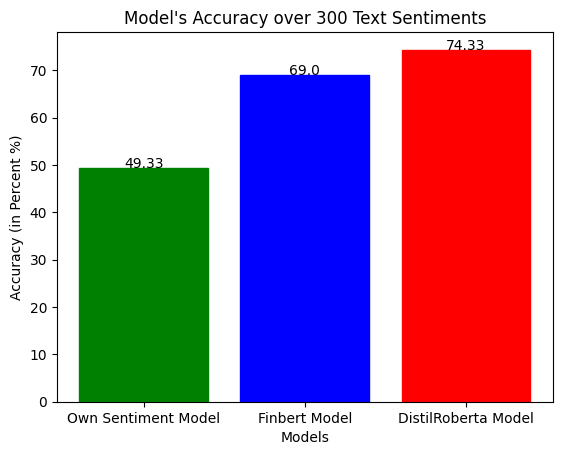

In [ ]:
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

Models = ['Own Sentiment Model', 'Finbert Model', 'DistilRoberta Model']
Accuracy = [round(len(smt_matches)/len(smt), 4)*100, round(len(fmt_matches)/len(fmt), 4)*100, round(len(dmt_matches)/len(dmt), 4)*100]

bars = plt.bar(Models, Accuracy)
bars[0].set_color('green')
bars[1].set_color('blue')
bars[2].set_color('red')

# giving title to the plot
plt.title("Model's Accuracy over 300 Text Sentiments")

# giving X and Y labels
plt.xlabel("Models")
plt.ylabel("Accuracy (in Percent %)")

addlabels(Models, Accuracy)

plt.show()